In [1]:
import os

import datetime

import numpy as np
import pandas as pd
from pprint import pprint

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import torch.utils.data as Data

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, random_split

import h5py

from tqdm import tqdm

In [2]:
data_dir = "/home/gsainton/CALER/PEATMAP/1_NN_training/training_data"
datafile = "trainingData_n50w100.mat"


# Get list of mat file in data_dir
def get_files(data_dir):
    files = []
    for file in os.listdir(data_dir):
        if file.endswith(".mat") and file.startswith("trainingData"):
            files.append(file)
    return files

list_files = get_files(data_dir)
pprint(list_files)
print(f"There are {len(list_files)} files in the directory")


# Function to load data from mat file, select randmly a subset of the data and return it as a tensor
def make_subset_data(data_dir, datafile, frac_samples=0.3, seed=42, verbose=False):
    # Load data
    with h5py.File(os.path.join(data_dir, datafile), 'r') as f:
        input = f.get('input')
        arr_input = np.array(input)
        # convert to float64
        arr_input = arr_input.astype(np.float32)
        arr_input = arr_input.T
        
        latS = f.get('latS')
        arr_latS = np.array(latS)
        # convert to float32
        arr_latS = arr_latS.astype(np.float32)
        arr_latS = arr_latS.T

        lonS = f.get('lonS')
        arr_lonS = np.array(lonS)
        # convert to float32
        arr_lonS = arr_lonS.astype(np.float32)
        arr_lonS = arr_lonS.T
        
        # Concatenate the input data and the coordinates
        arr_input = np.concatenate((arr_input, arr_latS, arr_lonS), axis=1)

        target = f.get('target')
        arr_target = np.array(target)
        print(f"Shape of target: {arr_target.shape}")
        # convert to float32
        arr_target = arr_target.astype(np.float32)
        arr_target = arr_target.T

        # Convert to PyTorch tensors
        X = torch.from_numpy(arr_input)
        y = torch.from_numpy(arr_target)
    
    nb_lines = X.shape[0]
    nb_lines2extract = int(nb_lines * frac_samples)
    if verbose:
        print(f"Filenames: {datafile}  ")
        print(f"Number of lines in the file: {nb_lines}")
        print(f"Number of lines to extract: {nb_lines2extract}")

    # Select a random subset of the data
    np.random.seed(seed)
    idx = np.random.choice(X.shape[0], nb_lines2extract, replace=False)
    X = X[idx]
    y = y[idx]

    return X, y

# Functio to stack the subsets of data from a list of files into a single tensor
def stack_data(data_dir, list_files, frac_samples=0.3, seed=42, 
               save2pd=False, output_dir="../outputs/", verbose=False):
    X = []
    y = []
    for file in list_files:
        X_, y_ = make_subset_data(data_dir, file, frac_samples, seed, verbose=verbose)
        X.append(X_)
        y.append(y_)

    X = torch.cat(X)
    y = torch.cat(y)
    if save2pd:
        # Save to pandas
        X = X.numpy()
        y = y.numpy()
        X = pd.DataFrame(X)

        #input fields
        X_fields = ['dist0005', 'dist0100', 'dist1000', 'hand0005',
          'hand0100', 'hand1000', 'slope',
          'elevation', 'wtd', 'landsat_1', 'landsat_2',
          'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6',
          'landsat_7', 'NDVI', 'lat', 'lon']
        X.columns = X_fields    

        #target fields
        y = pd.DataFrame(y)
        y_fields = ['peatland']
        y.columns = y_fields

        # Create a timestamp
        date_now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        filenameX = os.path.join(output_dir, f"X_merge_{date_now}.csv")
        print(f"Ouput file: {filenameX}")
        filenamey = os.path.join(output_dir, f"y_merge_{date_now}.csv")
        X.to_csv(filenameX)
        y.to_csv(filenamey)
        if verbose:
            print(f"Data saved to {output_dir}")
            print(f"X shape: {X.shape}")
            print(f"y shape: {y.shape}")
        return None, None, filenameX, filenamey
    else: 
        return X, y, None, None


# #####################################
# Test the function
# #####################################


X, y, filenameX, filenamey = stack_data(data_dir, list_files[0:2], frac_samples=0.10, seed=42, 
                  save2pd=True, verbose=True)
if X is not None:
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    X.describe()

else:
    print("Data saved to csv")

 

['trainingData_n55w95.mat',
 'trainingData_n50w95.mat',
 'trainingData_n50w100.mat',
 'trainingData_n55w100.mat',
 'trainingData_n55w105.mat',
 'trainingData_n50w105.mat',
 'trainingData_n55w90.mat',
 'trainingData_n45w100.mat',
 'trainingData_n60w110.mat',
 'trainingData_n60w90.mat',
 'trainingData_n60w95.mat',
 'trainingData_n60w100.mat',
 'trainingData_n60w105.mat',
 'trainingData_n45w105.mat']
There are 14 files in the directory
Shape of target: (1, 30411141)
Filenames: trainingData_n55w95.mat  
Number of lines in the file: 30411141
Number of lines to extract: 3041114
Shape of target: (1, 23225897)
Filenames: trainingData_n50w95.mat  
Number of lines in the file: 23225897
Number of lines to extract: 2322589
Ouput file: ../outputs/X_merge_20240611_153429.csv
Data saved to ../outputs/
X shape: (5363703, 19)
y shape: (5363703, 1)
Data saved to csv


In [ ]:
file = filenameX

df = pd.read_csv(file)
print(df.head())


In [5]:
def load_dataset_pandas(datadir, filenameX, filenamey):
    X = pd.read_csv(filenameX)
    y = pd.read_csv(filenamey)

    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")

    # Drop the first column
    X = X.drop(columns=X.columns[0])
    y = y.drop(columns=y.columns[0])
    

    # Convert to PyTorch tensors
    X = torch.from_numpy(X.values)
    y = torch.from_numpy(y.values)


    return X, y

X, y = load_dataset_pandas(data_dir, filenameX, filenamey)

print(X.shape)
print(y.shape)

print(X[0:5])
print(y[0:5])

X shape: (5363703, 20)
y shape: (5363703, 2)
torch.Size([5363703, 19])
torch.Size([5363703, 1])
tensor([[ 3.4596e+03,  7.3971e+03,  4.0590e+04,  1.5978e+01,  2.3878e+01,
          3.7978e+01,  2.8224e-02,  2.6698e+02,  1.6211e+00,  3.1200e+02,
          4.1800e+02,  6.4900e+02,  6.2500e+02,  2.2750e+03,  2.2130e+03,
          1.2760e+03,  5.6897e-01,  5.8983e+01, -9.7807e+01],
        [ 1.0908e+03,  1.0438e+04,  1.0438e+04,  2.0956e+00,  3.9496e+01,
          3.9496e+01,  1.2393e-02,  1.4360e+02,  9.7746e-01,  2.8800e+02,
          4.1500e+02,  6.7800e+02,  6.4800e+02,  2.5710e+03,  1.7900e+03,
          9.7000e+02,  5.9739e-01,  5.8513e+01, -9.5877e+01],
        [ 6.3356e+02,  3.2547e+03,  5.5181e+03,  1.0814e+01,  2.3461e+01,
          2.8761e+01,  2.5460e-02,  1.9026e+02,  1.1005e+01,  3.1100e+02,
          3.5400e+02,  5.3900e+02,  4.9400e+02,  2.2520e+03,  2.0860e+03,
          1.0950e+03,  6.4020e-01,  5.9627e+01, -9.6590e+01],
        [ 1.1916e+03,  1.1916e+03,  4.3177e+04,  5.0

In [5]:
data_dir = "/home/gsainton/CALER/PEATMAP/1_NN_training/training_data"
datafile = "trainingData_n50w100.mat"

# Open the file into a dataframe

with h5py.File(os.path.join(data_dir, datafile), 'r') as f:
    input = f.get('input')
    arr_input = np.array(input)
    # convert to float64
    arr_input = arr_input.astype(np.float32)
    arr_input = arr_input.T

    latS = f.get('latS')
    arr_latS = np.array(latS)
    # convert to float32
    arr_latS = arr_latS.astype(np.float32)
    arr_latS = arr_latS.T

    lonS = f.get('lonS')
    arr_lonS = np.array(lonS)
    # convert to float32
    arr_lonS = arr_lonS.astype(np.float32)
    arr_lonS = arr_lonS.T

    # Concatenate the input data and the coordinates
    arr_input = np.concatenate((arr_input, arr_latS, arr_lonS), axis=1)

    target = f.get('target')
    arr_target = np.array(target)
    print(f"Shape of target: {arr_target.shape}")
    # convert to float32
    arr_target = arr_target.astype(np.float32)
    arr_target = arr_target.T

X = pd.DataFrame(arr_input)



Shape of target: (1, 17490682)
torch.Size([17490682, 19])
torch.Size([17490682, 1])


In [7]:
# Convert arr_input to a dataframe
X = pd.DataFrame(X)

#input fields

X_fields = ['dist0005', 'dist0100', 'dist1000', 'hand0005',
    'hand0100', 'hand1000', 'slope',
    'elevation', 'wtd', 'landsat_1', 'landsat_2',
    'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6',
    'landsat_7', 'NDVI', 'lat', 'lon']

X.columns = X_fields    

display(X.head())


AttributeError: 'DataFrame' object has no attribute 'numpy'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.0 MB/s eta 0:00:00a 0:00:01


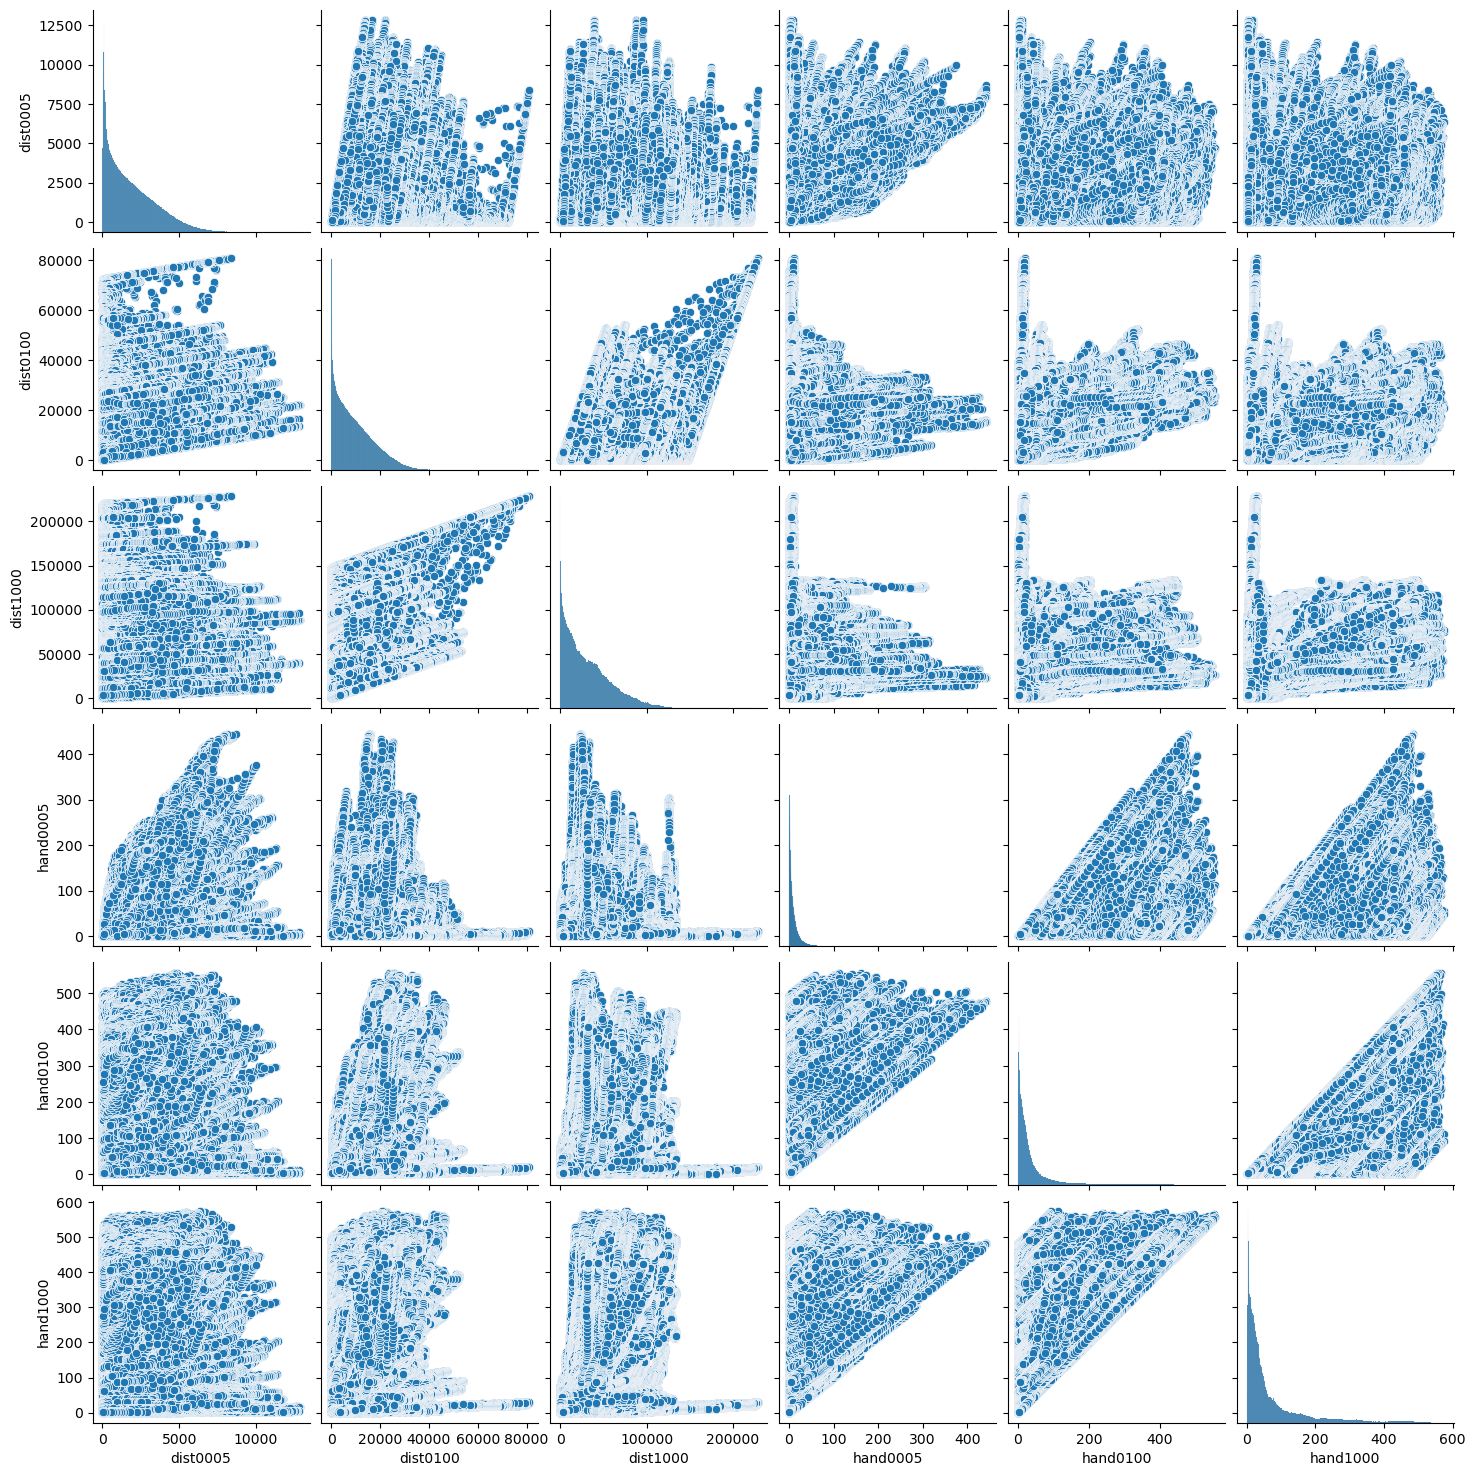

In [9]:
!pip install seaborn
# Scater plot of the data
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(X[['dist0005', 'dist0100', 'dist1000', 'hand0005',
    'hand0100', 'hand1000']])

<Axes: xlabel='dist0005', ylabel='Count'>

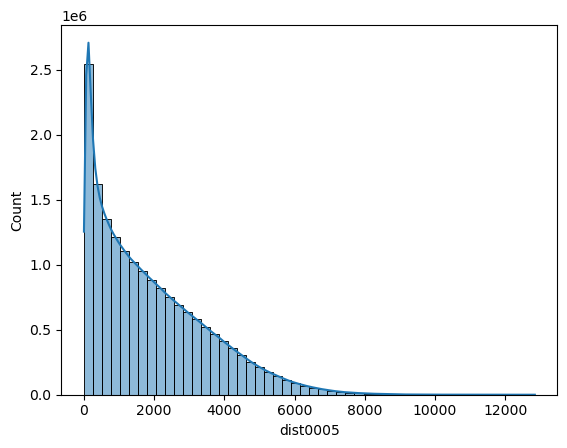

In [10]:
sns.histplot(data=X, x='dist0005', bins=50, kde=True)

19
0 dist0005
1 dist0100
2 dist1000
3 hand0005
4 hand0100
5 hand1000
6 slope
7 elevation
8 wtd
9 landsat_1
10 landsat_2
11 landsat_3
12 landsat_4
13 landsat_5
14 landsat_6
15 landsat_7
16 NDVI
17 lat
18 lon


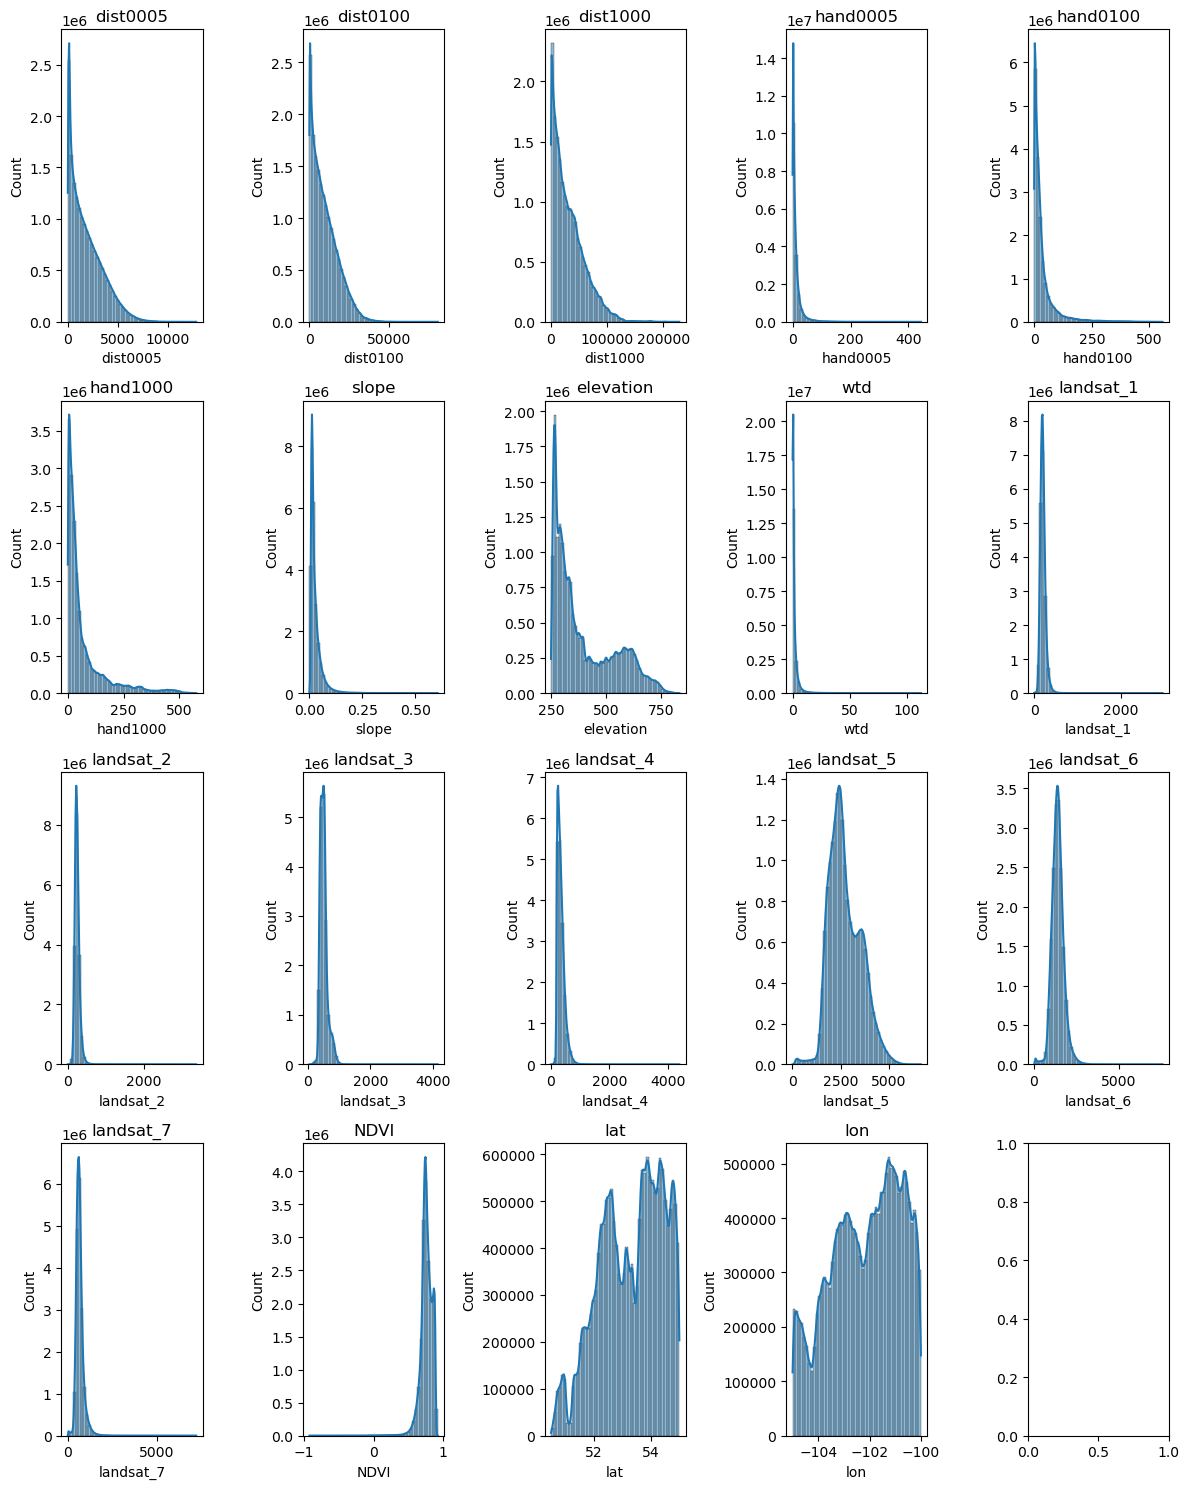

In [14]:
nb_plots = len(X_fields)
print(nb_plots)
ncol =int(np.ceil(np.sqrt(nb_plots)))
nrow = int(np.ceil(nb_plots / ncol))

fig, axs = plt.subplots(nrow, ncol, figsize=(12, 15))

for i, field in enumerate(X_fields):
    print(i, field)
    sns.histplot(data=X, x=field, bins=50, kde=True, ax=axs[i//ncol, i%ncol])
    axs[i//ncol, i%ncol].set_title(field)
plt.tight_layout()
plt.show()



In [17]:
# Print mean, std, skewness and kurtosis of the fields on one image per field
for i, field in enumerate(X_fields):
    if "lat" in field or "lon" in field:
        continue
    print(f"Field: {field} | Mean: {X[field].mean()} | Std: {X[field].std()} | Skewness: {X[field].skew()} | Kurtosis: {X[field].kurtosis()}")

    



Field: dist0005 | Mean: 1903.94580078125 | Std: 1618.7598876953125 | Skewness: 1.00692880153656 | Kurtosis: 0.6682461500167847
Field: dist0100 | Mean: 9869.455078125 | Std: 8108.79736328125 | Skewness: 1.0386888980865479 | Kurtosis: 1.163529872894287
Field: dist1000 | Mean: 32429.998046875 | Std: 27792.654296875 | Skewness: 1.2125498056411743 | Kurtosis: 1.8245388269424438
Field: hand0005 | Mean: 12.323905944824219 | Std: 19.67085075378418 | Skewness: 5.28288459777832 | Kurtosis: 45.89344787597656
Field: hand0100 | Mean: 37.30540466308594 | Std: 55.89571762084961 | Skewness: 3.64070725440979 | Kurtosis: 17.03474998474121
Field: hand1000 | Mean: 71.55975341796875 | Std: 94.81778717041016 | Skewness: 2.302198886871338 | Kurtosis: 5.410093307495117
Field: slope | Mean: 0.029097210615873337 | Std: 0.027812568470835686 | Skewness: 3.32482647895813 | Kurtosis: 18.262859344482422
Field: elevation | Mean: 399.9626159667969 | Std: 135.5670928955078 | Skewness: 0.8492038249969482 | Kurtosis: -0.

,peatland
0,33.141636
1,33.141636
2,33.141636
3,33.141636
4,33.141636


Field: peatland | Mean: 27.06081771850586 | Std: 14.632757186889648 | Skewness: 0.7709286212921143 | Kurtosis: 0.2028975933790207


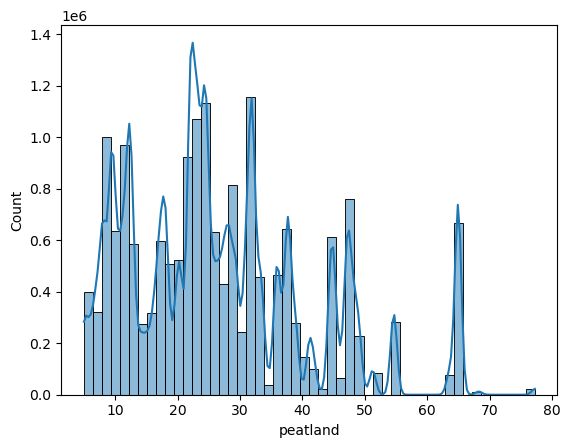

In [19]:
y = pd.DataFrame(arr_target)
y_fields = ['peatland']
y.columns = y_fields

display(y.head())

sns.histplot(data=y, x='peatland', bins=50, kde=True)
# Print mean, std, skewness and kurtosis of the fields on one image per field
for i, field in enumerate(y_fields):
    print(f"Field: {field} | Mean: {y[field].mean()} | Std: {y[field].std()} | Skewness: {y[field].skew()} | Kurtosis: {y[field].kurtosis()}")
    


In [20]:


# Champs à transformer avec Box-Cox
fields_to_transform = [
    'hand0005', 'hand0100', 'hand1000', 'slope', 'wtd',
    'landsat_1', 'landsat_2', 'landsat_3', 'landsat_4',
    'landsat_7', 'NDVI'
]

# Vérifier et transformer les champs
for field in fields_to_transform:
    # Ajouter une petite valeur constante si des valeurs sont inférieures ou égales à 0
    if any(X[field] <= 0):
        X[field] = X[field] - X[field].min() + 1
    # Appliquer la transformation Box-Cox
    X[field], _ = boxcox(X[field])

# Afficher les premières lignes pour vérifier
print(X.head())


# fields_to_log_transform = [
#     'hand0005', 'hand0100', 'hand1000', 'slope', 'wtd',
#     'landsat_1', 'landsat_2', 'landsat_3', 'landsat_4',
#     'landsat_7'
# ]

# # Vérifier et transformer les champs
# for field in fields_to_log_transform:
#     # Ajouter une petite valeur constante si des valeurs sont inférieures ou égales à 0
#     if any(X[field] <= 0):
#         X[field] = X[field] - X[field].min() + 1
#     # Appliquer la transformation logarithmique
#     X[field] = np.log(X[field])

# # Afficher les premières lignes pour vérifier
# print(X.head())



def box_cox_transform(X, fields_to_transform):
    for field in fields_to_transform:
        # Ajouter une petite valeur constante si des valeurs sont inférieures ou égales à 0
        if any(X[field] <= 0):
            X[field] = X[field] - X[field].min() + 1
        # Appliquer la transformation Box-Cox
        X[field], _ = boxcox(X[field])
    return X

inplace = True
if inplace:
    X = box_cox_transform(X, fields_to_transform)
else:
    X_boxcox = X.copy()
    X_boxcox = box_cox_transform(X_boxcox, fields_to_transform)

     dist0005    dist0100    dist1000  hand0005  hand0100  hand1000     slope  \
0   87.800491   87.800491   87.800491  2.217990  2.534485  2.636857 -2.725349   
1  140.468597  140.468597  140.468597  2.302229  2.646092  2.757886 -3.035905   
2  338.655426  338.655426  338.655426  2.284038  2.621873  2.731586 -3.737129   
3  560.529663  560.529663  560.529663  2.168004  2.468908  2.565945 -4.136845   
4  579.867371  579.867371  579.867371  1.984308  2.231926  2.310918 -4.272062   

    elevation       wtd  landsat_1  landsat_2  landsat_3  landsat_4  \
0  371.349487 -0.740197   8.364148   3.509830   2.588332   1.889033   
1  373.003723 -0.646195   8.708122   3.550484   2.598163   1.897506   
2  372.627869 -0.559623   8.794415   3.570165   2.601694   1.900805   
3  370.465271 -0.603811   8.644952   3.548455   2.593119   1.894624   
4  367.737305 -0.695103   9.498429   3.670961   2.635734   1.916484   

   landsat_5  landsat_6  landsat_7         NDVI        lat         lon  
0     2081.0 